In [1]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim.models.poincare import PoincareModel
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

### Preparing dataset

In [2]:
df = pd.read_csv('/workspaces/master_thesis/mapping/data_ready_to_use.csv')

In [3]:
df

,concept_id,concept_name,concept_synonym_name,preprocessed,preprocessed_synonyms,preprocessed_without_stemming,preprocessed_synonyms_without_stemming
0,4001098,Radiating chest pain,Radiating chest pain (finding),radiat chest pain,radiat chest pain find,radiating chest pain,radiating chest pain finding
1,37392117,Urine tryptophan:creatinine ratio,Urine tryptophan:creatinine ratio (observable ...,urin tryptophan creatinin ratio,urin tryptophan creatinin ratio observ entiti,urine tryptophan creatinine ratio,urine tryptophan creatinine ratio observable e...
2,37398455,Urine threonine:creatinine ratio,Urine threonine:creatinine ratio (observable e...,urin threonin creatinin ratio,urin threonin creatinin ratio observ entiti,urine threonine creatinine ratio,urine threonine creatinine ratio observable en...
3,37392118,Urine taurine:creatinine ratio,Urine taurine:creatinine ratio (observable ent...,urin taurin creatinin ratio,urin taurin creatinin ratio observ entiti,urine taurine creatinine ratio,urine taurine creatinine ratio observable entity
4,37392119,Urine phenylalanine:creatinine ratio,Urine phenylalanine:creatinine ratio (observab...,urin phenylalanin creatinin ratio,urin phenylalanin creatinin ratio observ entiti,urine phenylalanine creatinine ratio,urine phenylalanine creatinine ratio observabl...
...,...,...,...,...,...,...,...
491491,37398450,Urine homocysteine:creatinine ratio,Urine homocysteine:creatinine ratio (observabl...,urin homocystein creatinin ratio,urin homocystein creatinin ratio observ entiti,urine homocysteine creatinine ratio,urine homocysteine creatinine ratio observable...
491492,37398451,Urine aspartate:creatinine ratio,Urine aspartate:creatinine ratio (observable e...,urin aspart creatinin ratio,urin aspart creatinin ratio observ entiti,urine aspartate creatinine ratio,urine aspartate creatinine ratio observable en...
491493,37398452,Urine alanine:creatinine ratio,Urine alanine:creatinine ratio (observable ent...,urin alanin creatinin ratio,urin alanin creatinin ratio observ entiti,urine alanine creatinine ratio,urine alanine creatinine ratio observable entity
491494,37398453,Urine valine:creatinine ratio,Urine valine:creatinine ratio (observable entity),urin valin creatinin ratio,urin valin creatinin ratio observ entiti,urine valine creatinine ratio,urine valine creatinine ratio observable entity


In [4]:
class PhraseEmbeddingDataset(Dataset):
    def __init__(self, X, y, w2v_model, poincare_model, max_len=20):
        self.X = X
        self.y = y
        self.w2v_model = w2v_model
        self.poincare_model = poincare_model
        self.max_len = max_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get Word2Vec embedding
        X = self.get_phrase_vector(self.X.iloc[idx], self.w2v_model, self.max_len)
        
        # Get Poincare embedding
        y = torch.tensor(self.poincare_model.kv[self.y.iloc[idx]], dtype=torch.float)
        #y = torch.tensor(self.poincare_model.wv[str(self.y.iloc[idx])], dtype=torch.float)
        return X, y

    @staticmethod
    def get_phrase_vector(phrase, model, max_len):
        words = str(phrase).split()
        phrase_vector = np.zeros((max_len, model.vector_size))

        for i in range(max_len):
            if i < len(words) and words[i] in model.wv:
                phrase_vector[i] = model.wv[words[i]]

        phrase_vector = phrase_vector.flatten()
        
        return torch.tensor(phrase_vector, dtype=torch.float)



In [5]:
w2v_model = Word2Vec.load("/workspaces/master_thesis/word2vec_pubmed.model")
poincare_model = PoincareModel.load('/workspaces/master_thesis/poincare_100d_concept_id')
#deepwalk_model = Word2Vec.load("/workspaces/master_thesis/deepwalk_snomed.model")

In [6]:
# Split your phrases into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_synonyms_without_stemming'], df['concept_id'], test_size=0.02, random_state=42)

# Create your datasets
train_dataset = PhraseEmbeddingDataset(X_train, y_train, w2v_model, poincare_model)
#train_dataset = PhraseEmbeddingDataset(X_train, y_train, w2v_model, deepwalk_model)
test_dataset = PhraseEmbeddingDataset(X_test, y_test, w2v_model, poincare_model)
#test_dataset = PhraseEmbeddingDataset(X_test, y_test, w2v_model, deepwalk_model)

# Create your data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [33]:
len(train_dataset)

481666

In [34]:
len(test_dataset)

9830

### Training model

In [9]:
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # 2 for bidirection

    def forward(self, x):
        # Reshape the input to (batch_size, seq_len, features)
        x = x.view(x.size(0), 20, 300)

        # Forward propagate LSTM
        out, _ = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size*2)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [10]:
model = BiLSTM(input_size=300, hidden_size=300, output_size=100)

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

## TRAINING

In [11]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')


Epoch [1/10], Step [100/6144], Loss: 0.0071


KeyboardInterrupt: 

### Evaluation of the model for one sample

In [7]:
def hyporbolic_distance(x,y):
    #calculate hyporbolic distance between two vectors
    return np.arccosh(1 + 2 * np.linalg.norm(x-y)**2 / ((1 - np.linalg.norm(x)**2) * (1 - np.linalg.norm(y)**2)))

In [12]:
#load the model
model = BiLSTM(input_size=300, hidden_size=300, output_size=100)
model.load_state_dict(torch.load('/workspaces/master_thesis/model_50epochs_conceptid.ckpt'))
#device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval() 

BiLSTM(
  (lstm): LSTM(300, 300, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=600, out_features=100, bias=True)
)

In [13]:
def get_phrase_vector(phrase, model, max_len):
    words = str(phrase).split()
    phrase_vector = np.zeros((max_len, model.vector_size))
    for i in range(max_len):
        if i < len(words) and words[i] in model.wv:
            phrase_vector[i] = model.wv[words[i]]
    phrase_vector = phrase_vector.flatten()
    
    return torch.tensor(phrase_vector, dtype=torch.float)

In [154]:
X = get_phrase_vector('need air', w2v_model, 20)

In [155]:
#X convert to tensor in batch size 1
X = X.unsqueeze(0)

In [156]:
X

tensor([[ 0.3326,  1.0731, -1.4648,  ...,  0.0000,  0.0000,  0.0000]])

In [157]:
output = model(X)

In [158]:
#in poincare model find the closest vector to output
result=poincare_model.kv.most_similar(output.detach().numpy(), topn=10)

In [159]:
result

[(41915391, 0.42863416765340157),
 (41921547, 0.4314627566705844),
 (42084627, 0.43777691312447425),
 (41928899, 0.4407916765806594),
 (41970930, 0.4423210165064817),
 (42084633, 0.45195987140321336),
 (41931105, 0.4555826067213374),
 (42035287, 0.4580422569455974),
 (41987173, 0.45827651653050283),
 (41931093, 0.46027270938342174)]

In [160]:
for i in range(len(result)):
    #concatenate dataframes with results 
    if i == 0:
        df_result = df[df['concept_id'] == result[i][0]]
    else:
        df_result = pd.concat([df_result, df[df['concept_id'] == result[i][0]]])

In [161]:
df_result

,concept_id,concept_name,concept_synonym_name,preprocessed,preprocessed_synonyms,preprocessed_without_stemming,preprocessed_synonyms_without_stemming


In [162]:
df_concept=pd.read_csv('/workspaces/master_thesis/CONCEPT.csv', on_bad_lines='skip', sep='\t')

/tmp/ipykernel_3016832/1399977619.py:1: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_concept=pd.read_csv('/workspaces/master_thesis/CONCEPT.csv', on_bad_lines='skip', sep='\t')


In [163]:
for i in range(len(result)):
    #concatenate dataframes with results 
    if i == 0:
        df_result = df_concept[df_concept['concept_id'] == result[i][0]]
    else:
        df_result = pd.concat([df_result, df_concept[df_concept['concept_id'] == result[i][0]]])

In [164]:
df_result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
68037,41915391,Demjok,Geography,OSM,3rd level,S,2713466,19700101,20991231,NaN
67588,41921547,China,Geography,OSM,2nd level,S,270056,19700101,20991231,NaN
1242651,42084627,Midwest,Geography,US Census,US Census Region,S,0200000US2,19700101,20991231,NaN
26901,41928899,Metropolitan France,Geography,OSM,3rd level,S,1403916,19700101,20991231,NaN
136054,41970930,Germany,Geography,OSM,2nd level,S,51477,19700101,20991231,NaN
1242657,42084633,West North Central,Geography,US Census,US Census Division,S,0300000US4,19700101,20991231,NaN
108221,41931105,New Aquitaine,Geography,OSM,4th level,S,3792880,19700101,20991231,NaN
149547,42035287,England,Geography,OSM,4th level,S,58447,19700101,20991231,NaN
105434,41987173,Italy,Geography,OSM,2nd level,S,365331,19700101,20991231,NaN
108219,41931093,Auvergne-Rhône-Alpes,Geography,OSM,4th level,S,3792877,19700101,20991231,NaN


In [158]:
poincare_model.kv.ancestors(result[0][0])

['development disord', 'degen disord', 'diseas', 'chronic diseas', 'japan']

In [160]:
poincare_model.kv.closest_parent(result[0][0])

'development disord'

In [159]:
poincare_model.kv.closest_child(result[0][0])

'famili diseas'

In [35]:
df[df['concept_id']==4329847]

,concept_id,concept_name,concept_synonym_name,preprocessed,preprocessed_synonyms,preprocessed_without_stemming,preprocessed_synonyms_without_stemming
0,4001098,Radiating chest pain,Radiating chest pain (finding),radiat chest pain,radiat chest pain find,radiating chest pain,radiating chest pain finding


In [316]:
poincare_model.kv.most_similar('myocardi infarct', topn=5)

[('ischem heart diseas', 0.8100460146831875),
 ('subendocardi myocardi infarct', 0.8388786891377829),
 ('myocardi ischemia', 0.9273830320340807),
 ('myocardi necrosi', 0.9710507992408491),
 ('acut ischem heart diseas', 1.0094027734368483)]

In [139]:
#get unique concept_ids
df_result['concept_name'].unique()

array(['Procedure on cardiovascular system', 'Emergency procedure',
       'Procedure by site', 'Procedure site', 'Procedure on body system',
       'Procedure by method'], dtype=object)

In [140]:
vector_names = ['Procedure on cardiovascular system', 'Emergency procedure',
       'Procedure by site',  'Procedure on body system',
       'Procedure by method']

In [141]:
node_name='artery detect'

In [142]:
#get vectors of the most similar 
vectors = []
for i in range(len(result)):
    vectors.append(poincare_model.kv[result[i][0]])
#plot them in 2D



In [143]:
# Function to convert Poincaré coordinates to Euclidean
def poincare_to_euclidean(poincare_vec):
    norm_sq = np.sum(poincare_vec ** 2)
    denominator = 1 + norm_sq
    euclidean_vec = (2 / denominator) * poincare_vec
    euclidean_vec = np.append(euclidean_vec, (1 - norm_sq) / denominator)
    return euclidean_vec

In [144]:
# Function to convert Poincaré coordinates to Euclidean
def poincare_to_euclidean(poincare_vec):
    norm_sq = np.sum(poincare_vec ** 2)
    denominator = 1 + norm_sq
    euclidean_vec = (2 / denominator) * poincare_vec
    euclidean_vec = np.append(euclidean_vec, (1 - norm_sq) / denominator)
    return euclidean_vec

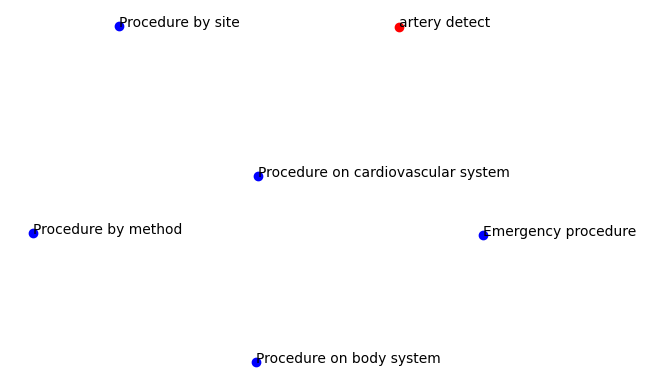

In [132]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_embeddings(node_vector, vectors, node_name, vector_names):
    # Reshape vectors in 'vectors' list to match the shape of 'node_vector'
    vectors = [vector.reshape(1, -1) for vector in vectors]

    # Combine node_vector and its similar vectors
    embeddings = np.vstack([node_vector] + vectors)

    # Combine node_vector and its similar vectors
    embeddings = np.vstack([node_vector] + vectors)

    tsne = TSNE(n_components=2, random_state=0, perplexity=5)  # set perplexity to 5
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.scatter(embeddings_2d[1:, 0], embeddings_2d[1:, 1], color='blue')  # similar vectors in blue
    plt.scatter(embeddings_2d[0, 0], embeddings_2d[0, 1], color='red')  # node_vector in red

    # Annotate points with vector names
    plt.annotate(node_name, (embeddings_2d[0, 0], embeddings_2d[0, 1]))
    for i, name in enumerate(vector_names, 1):
        plt.annotate(name, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

    plt.axis('off')  # Hide axes
    plt.show()

# Transform vectors
euclidean_node_vector = poincare_to_euclidean(output.detach().numpy())
euclidean_vectors = [poincare_to_euclidean(vector) for vector in vectors]


# Assume your node_vector is defined, and you have collected the similar vectors
visualize_embeddings(euclidean_node_vector, euclidean_vectors, node_name, vector_names)


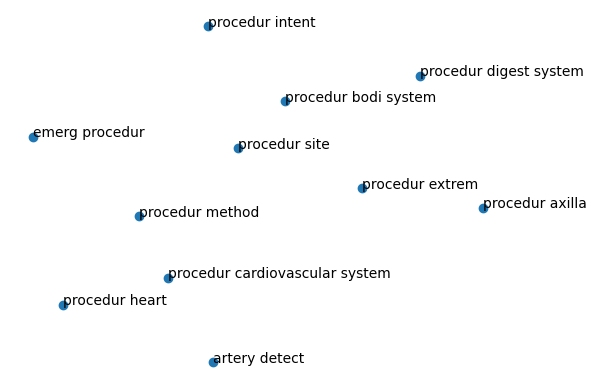

In [134]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get the vector for your node
node = 'artery detect'
node_vector = output.detach().numpy()

# Get the vectors for the 5 most similar nodes
similar_nodes = poincare_model.kv.most_similar(node_vector, topn=10)
similar_vectors = [poincare_model.kv.get_vector(n) for n, _ in similar_nodes]

# Convert Poincaré vectors to Euclidean
node_vector = poincare_to_euclidean(node_vector)
similar_vectors = [poincare_to_euclidean(vec) for vec in similar_vectors]

# Stack your node's vector and the similar vectors into a single array
vectors = np.vstack([node_vector] + similar_vectors)

# Use t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=5)
vectors_2d = tsne.fit_transform(vectors)

# Plot the vectors in 2D
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])


# Annotate the points with their corresponding node names
for i, (x, y) in enumerate(vectors_2d):
    if i == 0:
        plt.annotate(node, (x, y))
    else:
        plt.annotate(similar_nodes[i-1][0], (x, y))
        
plt.axis('off')
plt.show()


In [89]:
node_vector = output.detach().numpy()

In [90]:
node_vector.shape

(1, 100)

In [91]:
for vector in vectors:
    print(vector.shape)

(100,)
(100,)
(100,)
(100,)
(100,)


### Evaluation of the model

In [29]:
#load the model
model = BiLSTM(input_size=300, hidden_size=300, output_size=100)
model.load_state_dict(torch.load('/workspaces/master_thesis/model_50epochs.ckpt'))
#device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval() 
k_values = [1, 5, 10, 20, 50]
accuracy_values = []

with torch.no_grad():
    for k in k_values:
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            outputs = outputs.cpu().numpy()
            labels = labels.cpu().numpy()
            for i in range(len(outputs)):
                distances = []
                for j in range(len(labels)):
                    distances.append(hyporbolic_distance(outputs[i], labels[j]))
                # get the indices of the k nearest neighbors
                indices = np.argsort(distances)[:k]
                # get the labels of the k nearest neighbors
                nearest_neighbors = labels[indices]
                # check if the true label is among the k nearest neighbors
                true_label = labels[i]
                if true_label in nearest_neighbors:
                    correct += 1
                total += 1
        accuracy = correct / total
        accuracy_values.append(accuracy)
        
for i, accuracy in zip(k_values, accuracy_values):
    print(f"Accuracy for k={i}: {accuracy * 100}%")

/tmp/ipykernel_2295969/2664624457.py:3: RuntimeWarning: invalid value encountered in arccosh
  return np.arccosh(1 + 2 * np.linalg.norm(x-y)**2 / ((1 - np.linalg.norm(x)**2) * (1 - np.linalg.norm(y)**2)))


KeyboardInterrupt: 

In [13]:
labels[0]

array([ 0.19665678,  0.02667253, -0.02934773, -0.01337146,  0.04152124,
       -0.05577108,  0.14011106,  0.09187503, -0.12093822,  0.02160995,
       -0.0131025 , -0.08683918,  0.00625619,  0.06242204, -0.08745344,
       -0.05218282,  0.12236204, -0.01187435,  0.05717341, -0.04063322,
       -0.05357431,  0.25135383, -0.11989627,  0.00989363, -0.15431452,
       -0.10989917,  0.16160643, -0.05924424,  0.03936768,  0.03939102,
       -0.06837179, -0.03936594, -0.06925329,  0.0287062 , -0.02164807,
       -0.01854842,  0.05298658, -0.10234008,  0.06967802, -0.11811987,
        0.07652353, -0.01244717, -0.003803  , -0.02318858,  0.12595965,
        0.13021925,  0.22862007,  0.12428559, -0.12883334,  0.19415568,
        0.01169046, -0.13112605, -0.05151721, -0.24994433,  0.07567984,
        0.10239729, -0.08897179,  0.07758136, -0.04398337, -0.07124443,
       -0.00111799, -0.02667818,  0.01939244, -0.02062713, -0.04814637,
        0.02442436,  0.02604907,  0.01920782, -0.11671887,  0.00

In [16]:
model.eval()
k_values = [1, 5, 10, 20, 50]
accuracy_values = []

with torch.no_grad():
    # Load all data into memory
    inputs_all = []
    labels_all = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs_all.append(inputs)
        labels_all.append(labels)

    inputs_all = torch.cat(inputs_all)
    labels_all = torch.cat(labels_all)

    # Compute outputs for all data
    outputs_all = model(inputs_all)
    outputs_all = outputs_all.cpu().numpy()
    labels_all = labels_all.cpu().numpy()

    for k in k_values:
        correct = 0
        total = 0
        for i in range(len(outputs_all)):
            distances = []
            for j in range(len(labels_all)):
                distances.append(hyporbolic_distance(outputs_all[i], labels_all[j]))
            # get the indices of the k nearest neighbors
            indices = np.argsort(distances)[:k]
            # get the labels of the k nearest neighbors
            nearest_neighbors = labels_all[indices]
            # check if the true label is among the k nearest neighbors
            true_label = labels_all[i]
            if true_label in nearest_neighbors:
                correct += 1
            total += 1
        accuracy = correct / total
        accuracy_values.append(accuracy)

for i, accuracy in zip(k_values, accuracy_values):
    print(f"Accuracy for k={i}: {accuracy * 100}%")

/tmp/ipykernel_1793303/2664624457.py:3: RuntimeWarning: invalid value encountered in arccosh
  return np.arccosh(1 + 2 * np.linalg.norm(x-y)**2 / ((1 - np.linalg.norm(x)**2) * (1 - np.linalg.norm(y)**2)))


KeyboardInterrupt: 

In [16]:
#load the model
model = BiLSTM(input_size=300, hidden_size=300, output_size=100)
model.load_state_dict(torch.load('model.ckpt'))
#device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#get predicted label from the model and calculate the distance between the predicted label and the true label
model.eval() 
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        outputs = outputs.cpu().numpy()
        print(outputs)
        print(outputs.shape)
        labels = labels.cpu().numpy()
        print(labels)
        print(labels.shape)
        distance = hyporbolic_distance(outputs, labels)
        print(distance)
        #stop after one iteration
        break

[[ 0.15149002 -0.00588327 -0.01927167 ...  0.13347381  0.05824211
  -0.110452  ]
 [ 0.09172472  0.01436075  0.04251928 ... -0.04174102  0.03248358
  -0.01895724]
 [ 0.03682062  0.01093031  0.01620699 ...  0.02730098  0.00170489
  -0.02050288]
 ...
 [ 0.13538103  0.09132892 -0.00368471 ...  0.16022784 -0.01432297
   0.05173496]
 [-0.0598892   0.07564677 -0.04869265 ... -0.0221441   0.00432681
   0.13782363]
 [ 0.02208643  0.06257834 -0.00210662 ...  0.08658007 -0.00262798
  -0.01696791]]
(64, 100)
[[ 0.19665678  0.02667253 -0.02934773 ...  0.18277912  0.03209405
  -0.08987681]
 [ 0.18238278  0.15877901  0.08966684 ...  0.02679526 -0.00069893
  -0.07635263]
 [ 0.04590896 -0.00326635  0.1301228  ... -0.10906892  0.13626042
  -0.28794193]
 ...
 [ 0.1141592   0.08765475  0.00559242 ...  0.09552231 -0.05993672
   0.04217599]
 [-0.07532855  0.06801189 -0.0207578  ...  0.01642261 -0.00719422
   0.10086993]
 [ 0.08028945  0.04673268  0.05113677 ...  0.03378233 -0.10373269
  -0.0321836 ]]
(64, 1